# Leveraging Vector Databases with embeddings for fast image search and retrieval

### Setup

Before running this notebook:

1. Create cluster in Weaviate Console
2. Get API Key and URL

In [ ]:
!pip install -U weaviate-client
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.7/325.7 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.8/223.8 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.2/309.2 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.

### Connect to Weaviate vector database

In [ ]:
import weaviate
import json
import os

client = weaviate.Client(
    url = "YOUR_WEAVIATE_URL",
    auth_client_secret=weaviate.AuthApiKey(api_key="YOUR_API_KEY"),
)

### Upload dataset with vectors

In [ ]:
from google.colab import files
import pandas as pd
import io

uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded['vectors.csv']), sep=';', index_col=0)
df = df.reset_index()
df.head()

Saving vectors.csv to vectors.csv


index                            product_id  season_year brand_label  \
0      0                               8612301       2020.0        DITA   
1      1  018dc1e4-9d0f-4548-baa9-d8b62549fa85          NaN         NaN   
2      2                               8227830       2012.0       WEDZE   
3      3                               8170111       2011.0         VMC   
4      4  f692a4e1-4bb7-4cf2-992a-7a0cf2c090fe          NaN         NaN   

  gender_label                                          image_url  \
0         KIDS  https://contents.mediadecathlon.com/p1855779/s...   
1          NaN  https://contents.mediadecathlon.com/m11391253/...   
2      WOMEN'S  https://contents.mediadecathlon.com/p629818/sq...   
3    NO GENDER  https://contents.mediadecathlon.com/p823162/sq...   
4          NaN  https://contents.mediadecathlon.com/m7952071/k...   

  sports_id_list  dsm_code color_label  nature_id  \
0            169  X8612301  LIGHT PINK   576630.0   
1            NaN       NaN         NaN        NaN   
2    232|233|234  X8227830         N/D   296992.0   
3             99  X8170111         N/D   500384.0   
4            NaN       NaN         NaN        NaN   

                               sports_labels_list  \
0                                    field hockey   
1                                             NaN   
2  alpine skiing|freeride skiing|freestyle skiing   
3                                       athletics   
4                                             NaN   

                    product_label  nature_label  gender_id   image_id  \
0  STICK DITA MEGATEC ENFANT PINK  HOCKEY STICK        4.0   p1855779   
1                             NaN           NaN        NaN  m11391253   
2    FLOWFIT L SL2 MADRAS LIME 12    BASE LAYER        3.0    p629818   
3                    HOOK 7356 BN         HOOKS       13.0    p823162   
4                             NaN           NaN        NaN   m7952071   

  country_code    active                                             vector  
0          old    active  [-0.01212814450263977, 0.32004088163375854, 0....  
1  marketplace  inactive  [-0.05312139168381691, 0.016751728951931, -0.0...  
2          old    active  [0.2695339024066925, 0.090487040579319, 0.0400...  
3          old    active  [0.25236183404922485, -0.6132733225822449, 0.3...  
4  marketplace  inactive  [0.09365296363830566, 0.2518293261528015, 0.03...

### Define data collection

We define a data collection (a "collection" in Weaviate) to store objects in. This is analogous to creating a table in relational (SQL) databases.

In [ ]:
# Class definition object. Weaviate's autoschema feature will infer properties when importing.
class_obj = {
    "class": "Images",
    "vectorizer": "none",
}

# Add the class to the schema
client.schema.create_class(class_obj)

### Store data in Weaviate

- Import and load objects from the dataset
- Adds objects to the data collection one by one.

In [ ]:
import ast

vector_lists = [] # add all vectors from the dataset

# Configure a batch process
client.batch.configure(batch_size=100)  # Configure batch
with client.batch as batch:
  for index, row in df.iterrows():
    print(f"importing data: {row['image_url']}, {row['product_id']}")

    # one data point
    properties = {
        "product_id":row['product_id'],
        "image_url":  row['image_url'],
    }

    # convert string vector to list
    img_vector = ast.literal_eval(row["vector"])
    vector_lists.append(img_vector)

    # add one data point as dict and the vector
    batch.add_data_object(properties, "Images", vector=img_vector)

importing data: https://contents.mediadecathlon.com/p1855779/sq/1855779.jpg?f=224x224, 8612301
importing data: https://contents.mediadecathlon.com/m11391253/k$148c4677adee0722821c354c34d12dc5/sq/Chaussures+de+running+Homme+Catamount+Brooks.jpg?f=224x0, 018dc1e4-9d0f-4548-baa9-d8b62549fa85
importing data: https://contents.mediadecathlon.com/p629818/sq/629818.jpg?f=224x224, 8227830
importing data: https://contents.mediadecathlon.com/p823162/sq/823162.jpg?f=224x224, 8170111
importing data: https://contents.mediadecathlon.com/m7952071/k$e6a785deba663f6196c073e6ef27c8a9/sq/Gants+courts+100+Sling.jpg?f=224x0, f692a4e1-4bb7-4cf2-992a-7a0cf2c090fe
importing data: https://contents.mediadecathlon.com/m1392352/k$fec89a310b5c6cb22bd09e66604b7847/sq/Laguna+28+Roller+glaci+re+sur+roues+bleu+pour+camping+et+randonn+e+26+Litres.jpg?f=224x0, c54a9b53-5473-4b6d-ad99-382dc577e07d
importing data: https://contents.mediadecathlon.com/m6899674/k$8dccf32081e8ef505f900880e729e15d/sq/Discadapter+Discadapter+Ann

## Queries

Now, the data and vectors are in Weaviate.

Since we have an input vector, we use the `Near Vector` operator to find objects with similar vectors.

In [ ]:
import torch
import clip
from PIL import Image

# Load CLIP encoder

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

def to_numpy(tensor):
    return (
        tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()
    )

100%|████████████████████████████████████████| 338M/338M [00:03<00:00, 116MiB/s]


In [ ]:
# Upload image
uploaded = files.upload()

Saving shoe.jpg to shoe.jpg


In [ ]:
# Preprocess image and get embedding
image = preprocess(Image.open("shoe.jpg")).unsqueeze(0).to(device)
with torch.no_grad():
    image_features = model.encode_image(image)
    image_features_np = to_numpy(image_features).tolist()[0]
    image_features_np = [fv for fv in image_features_np]

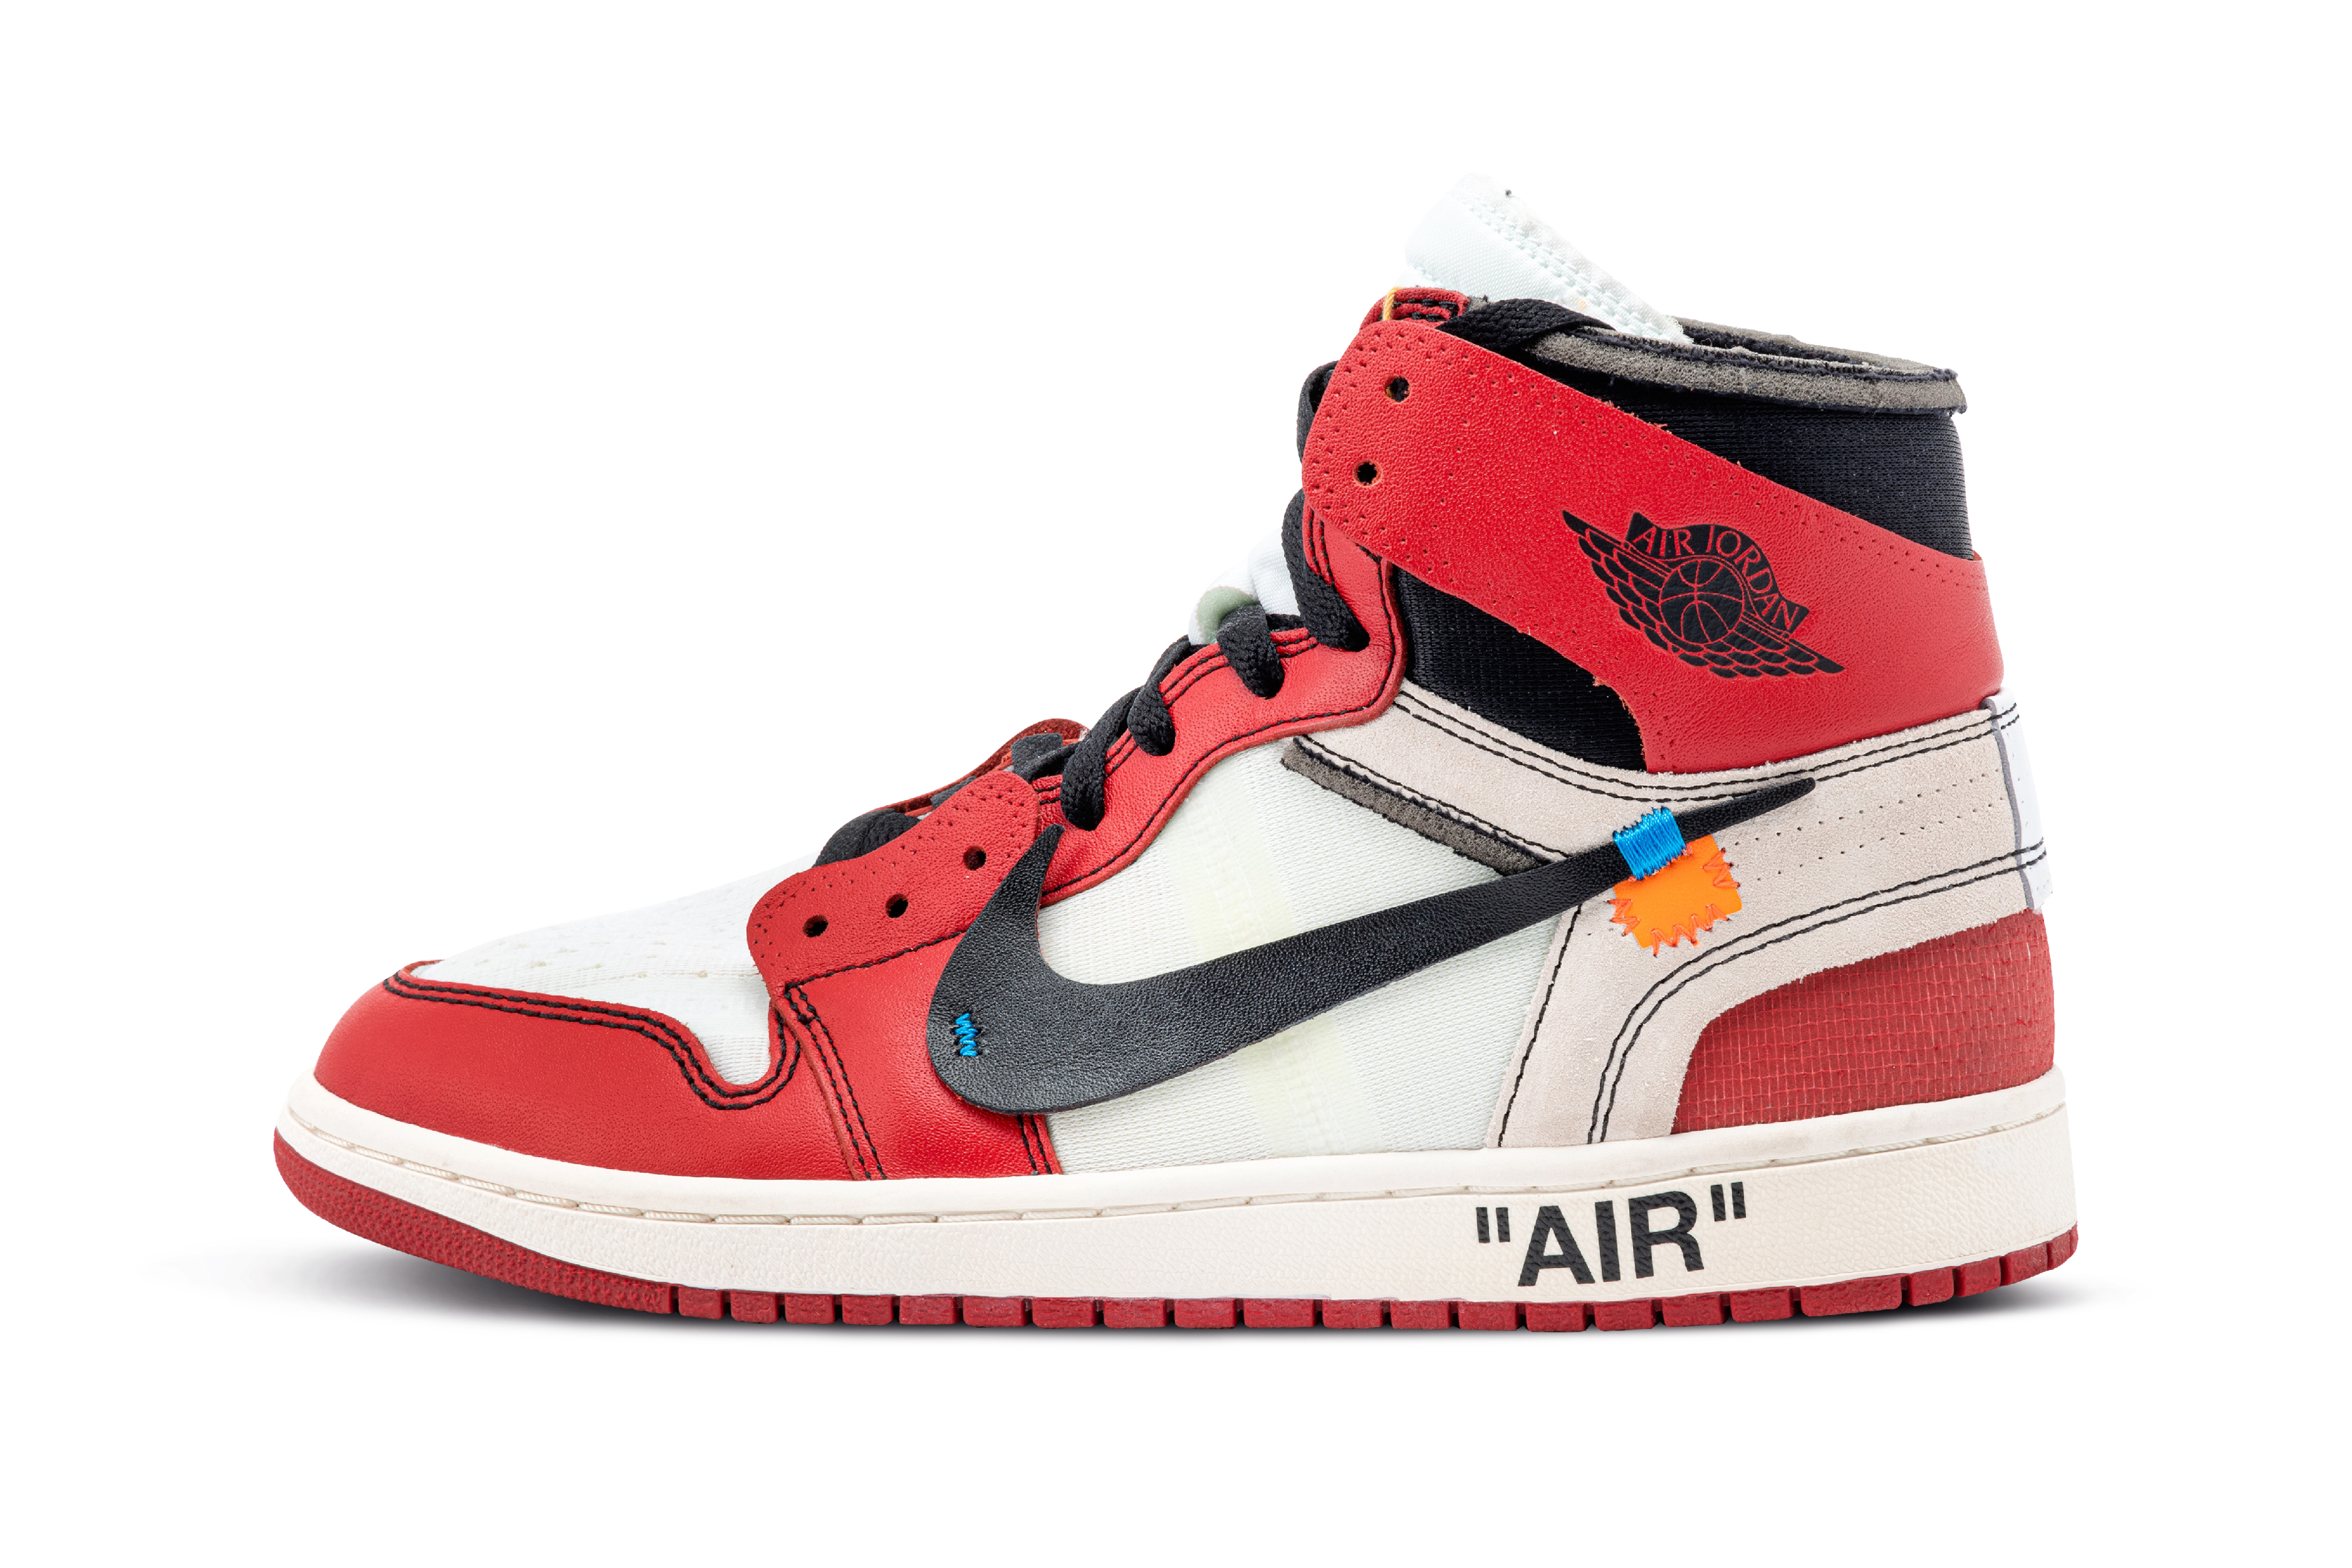

In [ ]:
Image.open("shoe.jpg")

In [ ]:
# query vector
nearVector = {
    "vector": image_features_np
}

# get nearest vector
result = client.query.get(
        "Images", ["product_id", "image_url"]
    ).with_near_vector(             # get nearest vector
        nearVector
    ).with_limit(3                  # top 3 results
    ).with_additional(['certainty'] # get certainity measure
    ).do()

print(json.dumps(result, indent=4))

{
    "data": {
        "Get": {
            "Images": [
                {
                    "_additional": {
                        "certainty": 0.7921097576618195
                    },
                    "image_url": "https://contents.mediadecathlon.com/p1291853/sq/1291853.jpg?f=224x224",
                    "product_id": "8493674"
                },
                {
                    "_additional": {
                        "certainty": 0.7880265116691589
                    },
                    "image_url": "https://contents.mediadecathlon.com/m11391253/k$148c4677adee0722821c354c34d12dc5/sq/Chaussures+de+running+Homme+Catamount+Brooks.jpg?f=224x0",
                    "product_id": "018dc1e4-9d0f-4548-baa9-d8b62549fa85"
                },
                {
                    "_additional": {
                        "certainty": 0.7830776572227478
                    },
                    "image_url": "https://contents.mediadecathlon.com/p1855779/sq/1855779.jpg?f=224x224

That is all. Now given our query image, we have the top 3 similar images from the dataset.